In [ ]:
import gensim
import gensim.downloader
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Call word2vec
w2v_model = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# GET the data
## Mounting path dari Google Colab
from google.colab import drive
drive.mount('/content/drive')

# path = "/content/drive/My Drive/Web Mining/"

Mounted at /content/drive


In [ ]:
## Memuat Data
import pandas as pd

dataset = pd.read_csv("/content/drive/My Drive/Web Mining/Testing_3000.csv", usecols=["Question Title Clean"])

In [ ]:
# EXPLORE the data
## Menampilkan lima data terakhir
dataset

,Question Title Clean
0,why do they say he bought the farm when someon...
1,when and where did the tradition of giving chr...
2,is cyber sex real
3,who are kurds
4,what kind of traditions you have to celebrate ...
...,...
2995,orlistat a k a xenical does this drug work
2996,anyone feel they have an undiagnosed case of m...
2997,how long does it take to get over having a hys...
2998,losing abdominal fat tyres around my waist


In [ ]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords
",".join(stopwords.words('english'))
stop_words=set(stopwords.words('english'))

def remove_stop(x):
  return ",".join([word for word in str(x).split() if word not in stop_words])

dataset["Question Title Clean"]=dataset["Question Title Clean"].apply(lambda x : remove_stop(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset

,Question Title Clean
0,"say,bought,farm,someone,dies"
1,"tradition,giving,christmas,presents,begin"
2,"cyber,sex,real"
3,kurds
4,"kind,traditions,celebrate,new,year"
...,...
2995,"orlistat,k,xenical,drug,work"
2996,"anyone,feel,undiagnosed,case,multple,personali..."
2997,"long,take,get,hysterectomy,total,strength,energy"
2998,"losing,abdominal,fat,tyres,around,waist"


In [ ]:
# MODEL the data
## Pra Pengolahan - Cleaning
import numpy as np
import re

def clean_text(tweet):

    # Convert to lower case
    tweet = tweet.lower()
    # remove unicode characters
    tweet = tweet.encode('ascii', 'ignore').decode()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    #ganti koma menjadi spasi
    tweet = tweet.replace(',',' ')
    return tweet

dataset["Question Title Clean"] = dataset['Question Title Clean'].map(lambda x: clean_text(x))
dataset = dataset[dataset['Question Title Clean'].apply(lambda x: len(x.split()) >=1)]

dataset

,Question Title Clean
0,say bought farm someone dies
1,tradition giving christmas presents begin
2,cyber sex real
3,kurds
4,kind traditions celebrate new year
...,...
2995,orlistat k xenical drug work
2996,anyone feel undiagnosed case multple personali...
2997,long take get hysterectomy total strength energy
2998,losing abdominal fat tyres around waist


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2993 entries, 0 to 2999
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Question Title Clean  2993 non-null   object
dtypes: object(1)
memory usage: 46.8+ KB


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.5 MB/s eta 0:00:00


In [ ]:
## Pra Pengolahan - Representasi Data
from transformers import AutoTokenizer, TFAutoModel

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFAutoModel.from_pretrained("bert-base-uncased", trainable=False)

def tokenisasi(teks):
    encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 128,
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

    tokenID = encode_dict['input_ids']
    attention_mask = encode_dict['attention_mask']

    return tokenID, attention_mask
    return tokenID

def bert(data):
    emb = []
    for teks in data:
        #print(teks)
        token, mask = tokenisasi(str(teks))
        emb.append(bert_model([token, mask])[1].numpy().tolist()[0])

    return emb

### BERT Embedding
bert_emb = np.array(bert(dataset.to_numpy()))

print(bert_emb.shape)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(2993, 768)


In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(2993, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/My Drive/Web Mining/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 3
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(2993,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words
    return top_n_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Question Title Clean"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['get', 'would', 'like', 'could', 'way', 'water', 'much', 'cold', 'people', 'skin'], ['get', 'one', 'day', 'find', 'good', 'would', 'think', 'people', 'best', 'know'], ['people', 'best', 'god', 'know', 'anyone', 'get', 'one', 'want', 'really', 'make']]


In [ ]:
### Topic Coherence
'''
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load(path + "Data/word2vec/idwiki-berita/w2v-model.bin")
'''

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model:
                if pair[1] in w2v_model:
                    pair_scores.append( abs(w2v_model.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)

        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score

    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))

0.2523449542690759


The number of topics is 2
The simulation 1
Coherence value :  0.22632519088478553
The simulation 2
Coherence value :  0.22632519088478553
The simulation 3
Coherence value :  0.22632519088478553
The simulation 4
Coherence value :  0.22632519088478553
The simulation 5
Coherence value :  0.22632519088478553
The number of topics is 3
The simulation 1
Coherence value :  0.2523449542690758
The simulation 2
Coherence value :  0.2523449542690758
The simulation 3
Coherence value :  0.2523449542690758
The simulation 4
Coherence value :  0.2523449542690759
The simulation 5
Coherence value :  0.2523449542690758
The number of topics is 4
The simulation 1
Coherence value :  0.24408481073462301
The simulation 2
Coherence value :  0.24408481073462301
The simulation 3
Coherence value :  0.24408481073462301
The simulation 4
Coherence value :  0.24408481073462301
The simulation 5
Coherence value :  0.24408481073462301
The number of topics is 5
The simulation 1
Coherence value :  0.21041027921355435
The s

Text(0, 0.5, 'Coherence')

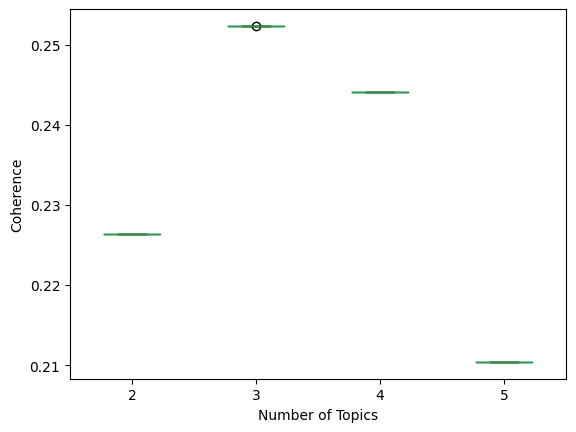

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(2,6,1):
    print("The number of topics is " + str(n_topics))

    coherence_sim = []
    for i in range(1,6):
        print("The simulation " + str(i))

        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)

        docs = pd.DataFrame(list(dataset["Question Title Clean"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])

    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
coh = []
for j in range(3):
    herence = []
    for i in range(10):
        herence.append(top_words[j][i])
    coh.append(herence)

In [ ]:
print(coh)

[['people', 'one', 'know', 'get', 'god', 'best', 'make', 'life', 'need', 'day'], ['get', 'would', 'like', 'tell', 'day', 'much', 'people', 'go', 'best', 'think'], ['best', 'people', 'anyone', 'god', 'one', 'religion', 'etc', 'church', 'theory', 'health']]


In [ ]:
import pandas as pd
pd.DataFrame(coh).T

,0,1,2
0,people,get,best
1,one,would,people
2,know,like,anyone
3,get,tell,god
4,god,day,one
5,best,much,religion
6,make,people,etc
7,life,go,church
8,need,best,theory
9,day,think,health


In [ ]:
coherence_topic = []
for topic_idx, terms in enumerate(coh):
    top_terms = [terms]
    coherence_topic.append(calculate_coherence(w2v_model, top_terms))
print(sum(coherence_topic)/len(coherence_topic))

0.20666037241893787
